In [1]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

/home/ejrueda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [40]:
class GANs():
    #inialização dos parâmetros
    def __init__(self, width, height, channels, noise_input):
        self.width = width
        self.height = height
        self.channels = channels
        self.dim = (self.width, self.height, self.channels)
        self.noise_input = noise_input
        self.g_loss = []
        self.d_loss = []
        #self.optimizer = Adam(lr=0.0001, beta_1=0.5)
        self.optimizer = Adam(lr=0.0002, beta_1=0.5)
        #self.optimizer2 = Adam(lr=0.0001, beta_1=0.5)
        self.G = self.noise_generator()
        print("Compilando o gerador...")
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        self.D = self.discriminator()
        print("Compilando o discriminador...")
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        self.stacked_generator_discriminator = Sequential()
        self.stacked_generator_discriminator.add(self.G)
        self.stacked_generator_discriminator.add(self.D)
        self.D.trainable = False
        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        
    #criação do gerador de imagens fake
    def noise_generator(self):
        model = Sequential()
        #7x7x112
        model.add(Dense(units=7*7*112, activation="tanh", input_shape=(self.noise_input,)))
        model.add(Reshape((7,7,112)))
        #14x14x56
        model.add(Conv2DTranspose(filters=56, kernel_size=(4,4), strides=(2,2), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        #28x28x28
        model.add(Conv2DTranspose(filters=28, kernel_size=(4,4), strides=(2,2), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        #28x28x1
        model.add(Conv2DTranspose(filters=1, kernel_size=(4,4), strides=(1,1),
                                  padding="same", activation="tanh"))
        
        #model.add(Dense(128, input_shape=(self.noise_input,)))
        #model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        #model.add(BatchNormalization(momentum=0.8)) #normalización de las capas anteriores
        #model.add(Dense(256))
        #model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(self.width  * self.height * self.channels, activation='tanh'))
        #model.add(Reshape((self.width, self.height, self.channels)))
        
        return model
    
    #criação do discriminador
    def discriminator(self):
        model = Sequential()
        #input 28x28x1 => 28x28x28
        model.add(Conv2D(filters=28, kernel_size=(4,4), strides=(1,1), input_shape=self.dim, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        #28x28x28 => 14x14x56
        model.add(Conv2D(filters=56, kernel_size=(4,4), strides=(2,2), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        #14x14x56 => 7x7x112
        model.add(Conv2D(filters=112, kernel_size=(4,4), strides=(2,2), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        #model.add(Flatten(input_shape=self.dim))
        #model.add(Dense((self.width * self.height * self.channels), input_shape=self.dim))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(Dense(np.int64((self.width * self.height * self.channels)/2)))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(Dense(1, activation='sigmoid'))
        
        return model

    #Para obter o sumary do gerador
    def summary_gerador(self):
        return self.G.summary()
    
    #Para obter o sumary do gerador
    def summary_discriminador(self):
        return self.D.summary()
        
    #pra obter os batches pra o treino
    def get_batches(self, X_train, batch_size):
        """
        X_train: dataset para o treino
        epochs: quantidade de epocas para o treino do gradiente
        batch: tamanho to batch pra o treino de cada epochs
        """
        batches = []
        num_bat = int(np.ceil(X_train.shape[0]/batch_size))
        lim_i = 0
        lim_s = batch_size
        for i in range(num_bat):
            if lim_s > X_train.shape[0]:
                lim_s = X_train.shape[0]
            batches.append(X_train[lim_i:lim_s])
            lim_i += batch_size
            lim_s += batch_size
            
        return batches
        
    #devolve o loss do gerador e do discriminador
    def get_loss(self):
        return [self.g_loss, self.d_loss]
    
    #treinamento da GAN
    def train(self, X_train, epochs, batch_size):
        self.d_loss = []
        self.g_loss = []
        for cnt in range(epochs):
            batches = obj_gan.get_batches(X_train, batch_size)
            count_b = 0
            t_i = time()
            for batch in batches:
                gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), self.noise_input))
                #gerando as imagens fake
                syntetic_images = self.G.predict(gen_noise)
                #criação do array de treinamento
                x_combined_batch = np.concatenate((batch, syntetic_images))
                y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                                   np.zeros((batch.shape[0], 1))))
                #treino do discriminador
                d_l = self.D.train_on_batch(x_combined_batch, y_combined_batch)
                self.d_loss.append(d_l[0])

                # train generator
                noise = np.random.normal(0, 1, (batch.shape[0], self.noise_input))
                y_mislabled = np.ones((batch.shape[0], 1))

                g_l = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)
                self.g_loss.append(g_l)
                count_b += 1
                if (count_b%20)==0:
                    t_f = time()
                    t = t_f - t_i
                    t_i = time()
                    print ('epoch:[%d/%d] batch:[%d/%d], [Discriminator::d_loss: %f], [Generator::loss: %f], %d[sec]'
                               % (cnt+1,epochs,count_b,len(batches),d_l[0],g_l,t))
                    num_imgs = 10 #número de imágenes a mostrar aleatoriamente
                    x = np.random.normal(0,1,(num_imgs,1000))
                    img_pre = obj_gan.G.predict(x)
                    fig = plt.figure(figsize=(12,4))
                    for i in range(num_imgs):
                        ax=fig.add_subplot(1,10,i+1)
                        plt.imshow(img_pre[i].reshape(28,28), cmap = plt.cm.Greys_r)
                        ax.axis("off")
                    plt.show()
                    

In [41]:
obj_gan = GANs(width=28,height=28,channels=1,noise_input=1000)

Compilando o gerador...
Compilando o discriminador...


In [42]:
obj_gan.G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 5488)              5493488   
_________________________________________________________________
reshape_9 (Reshape)          (None, 7, 7, 112)         0         
_________________________________________________________________
conv2d_transpose_25 (Conv2DT (None, 14, 14, 56)        100408    
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 14, 14, 56)        0         
_________________________________________________________________
conv2d_transpose_26 (Conv2DT (None, 28, 28, 28)        25116     
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 28, 28, 28)        0         
_________________________________________________________________
conv2d_transpose_27 (Conv2DT (None, 28, 28, 1)         449       
Total para

In [43]:
obj_gan.D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 28, 28, 28)        476       
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 28, 28, 28)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 14, 14, 56)        25144     
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 14, 14, 56)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 7, 7, 112)         100464    
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 7, 7, 112)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 5488)              0         
__________

/home/ejrueda/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [44]:
(X_train,_),(_,_) = mnist.load_data()
m = 255/2
X_train = (X_train - m)/m
X_train = np.expand_dims(X_train, axis=3)

/home/ejrueda/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:[1/5] batch:[20/469], [Discriminator::d_loss: 0.359942], [Generator::loss: 0.947934], 22[sec]


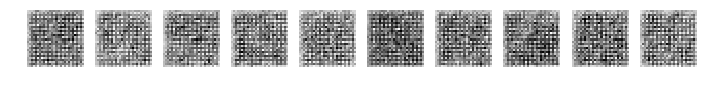

epoch:[1/5] batch:[40/469], [Discriminator::d_loss: 0.183863], [Generator::loss: 1.600630], 17[sec]


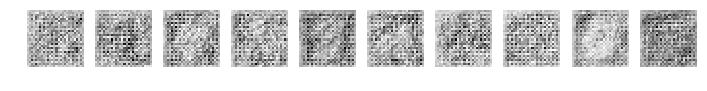

epoch:[1/5] batch:[60/469], [Discriminator::d_loss: 0.281361], [Generator::loss: 3.265477], 19[sec]


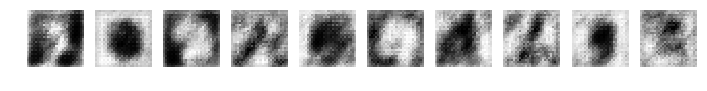

epoch:[1/5] batch:[80/469], [Discriminator::d_loss: 0.196925], [Generator::loss: 2.055886], 18[sec]


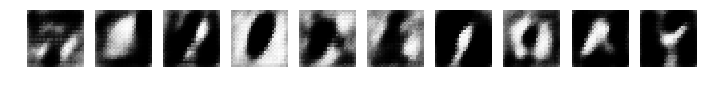

epoch:[1/5] batch:[100/469], [Discriminator::d_loss: 0.263691], [Generator::loss: 2.012018], 18[sec]


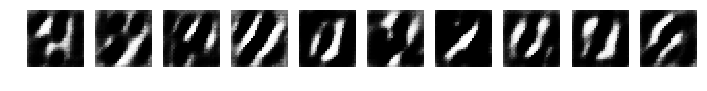

epoch:[1/5] batch:[120/469], [Discriminator::d_loss: 0.302973], [Generator::loss: 1.979701], 17[sec]


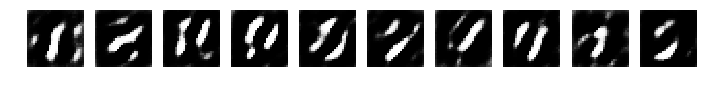

epoch:[1/5] batch:[140/469], [Discriminator::d_loss: 0.401422], [Generator::loss: 0.990321], 17[sec]


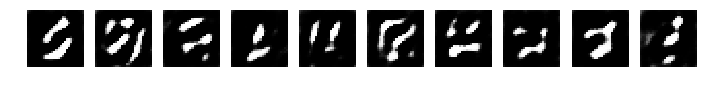

epoch:[1/5] batch:[160/469], [Discriminator::d_loss: 0.493924], [Generator::loss: 1.595569], 17[sec]


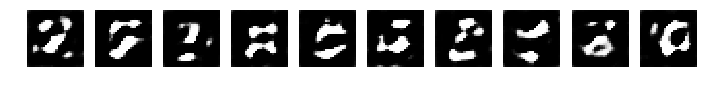

epoch:[1/5] batch:[180/469], [Discriminator::d_loss: 0.687309], [Generator::loss: 1.053318], 17[sec]


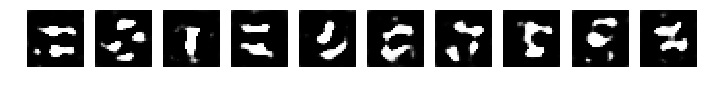

epoch:[1/5] batch:[200/469], [Discriminator::d_loss: 0.576237], [Generator::loss: 0.941421], 19[sec]


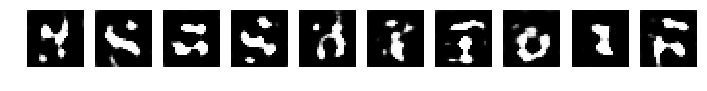

epoch:[1/5] batch:[220/469], [Discriminator::d_loss: 0.581066], [Generator::loss: 0.920984], 18[sec]


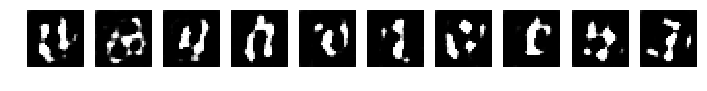

epoch:[1/5] batch:[240/469], [Discriminator::d_loss: 0.608405], [Generator::loss: 0.421654], 17[sec]


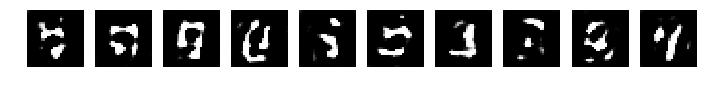

epoch:[1/5] batch:[260/469], [Discriminator::d_loss: 0.485731], [Generator::loss: 1.405858], 18[sec]


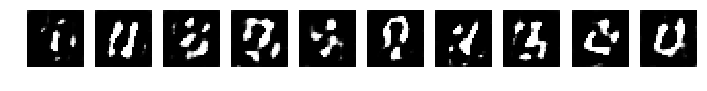

epoch:[1/5] batch:[280/469], [Discriminator::d_loss: 0.558637], [Generator::loss: 0.777793], 17[sec]


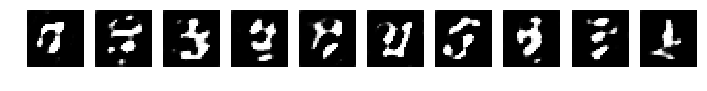

epoch:[1/5] batch:[300/469], [Discriminator::d_loss: 0.538083], [Generator::loss: 1.093078], 17[sec]


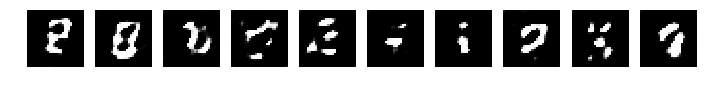

epoch:[1/5] batch:[320/469], [Discriminator::d_loss: 0.545465], [Generator::loss: 0.981513], 17[sec]


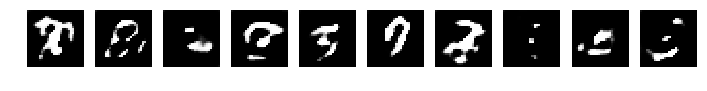

epoch:[1/5] batch:[340/469], [Discriminator::d_loss: 0.495899], [Generator::loss: 1.018260], 17[sec]


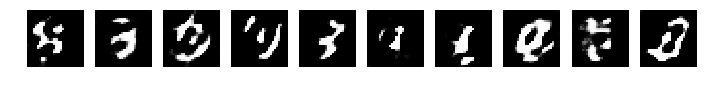

epoch:[1/5] batch:[360/469], [Discriminator::d_loss: 0.586455], [Generator::loss: 0.670099], 17[sec]


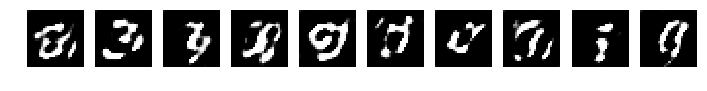

epoch:[1/5] batch:[380/469], [Discriminator::d_loss: 0.592339], [Generator::loss: 0.826357], 17[sec]


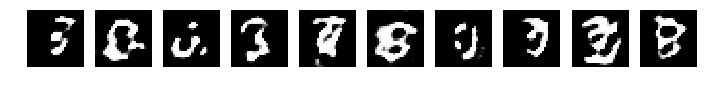

epoch:[1/5] batch:[400/469], [Discriminator::d_loss: 0.695143], [Generator::loss: 0.670151], 17[sec]


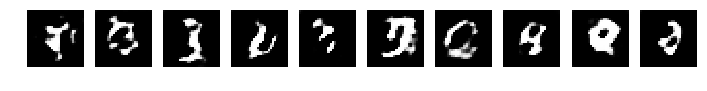

epoch:[1/5] batch:[420/469], [Discriminator::d_loss: 0.442986], [Generator::loss: 1.205077], 18[sec]


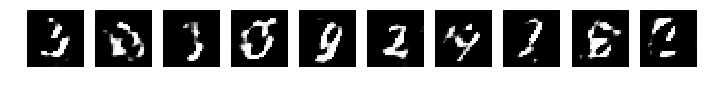

epoch:[1/5] batch:[440/469], [Discriminator::d_loss: 0.542420], [Generator::loss: 1.471278], 19[sec]


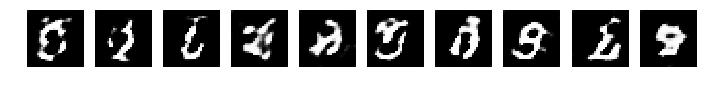

epoch:[1/5] batch:[460/469], [Discriminator::d_loss: 0.446035], [Generator::loss: 1.239137], 19[sec]


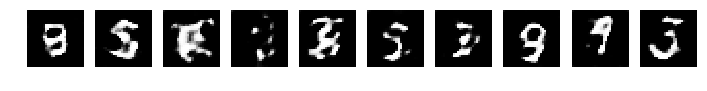

epoch:[2/5] batch:[20/469], [Discriminator::d_loss: 0.560699], [Generator::loss: 0.777146], 19[sec]


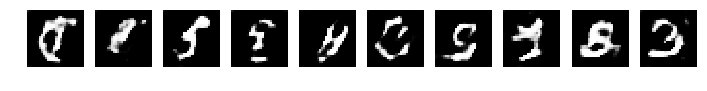

epoch:[2/5] batch:[40/469], [Discriminator::d_loss: 0.533169], [Generator::loss: 1.117424], 19[sec]


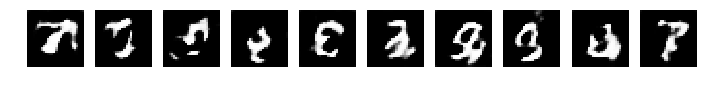

epoch:[2/5] batch:[60/469], [Discriminator::d_loss: 0.515478], [Generator::loss: 1.231724], 18[sec]


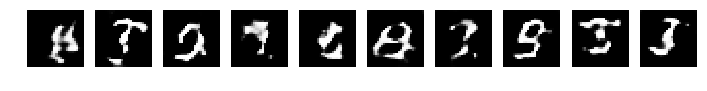

epoch:[2/5] batch:[80/469], [Discriminator::d_loss: 0.519914], [Generator::loss: 1.383481], 18[sec]


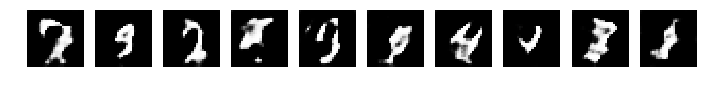

epoch:[2/5] batch:[100/469], [Discriminator::d_loss: 0.515267], [Generator::loss: 1.354929], 18[sec]


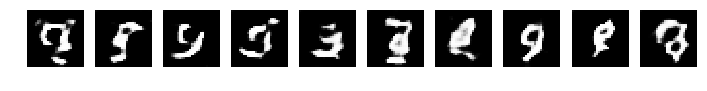

epoch:[2/5] batch:[120/469], [Discriminator::d_loss: 0.502905], [Generator::loss: 1.322016], 18[sec]


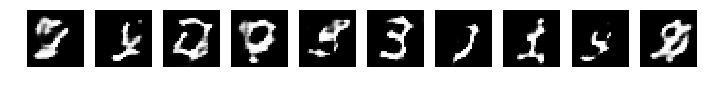

epoch:[2/5] batch:[140/469], [Discriminator::d_loss: 0.532186], [Generator::loss: 0.760609], 20[sec]


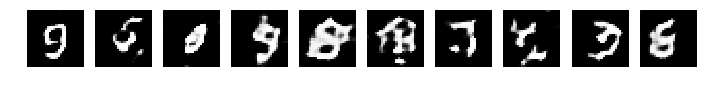

epoch:[2/5] batch:[160/469], [Discriminator::d_loss: 0.498765], [Generator::loss: 0.894188], 19[sec]


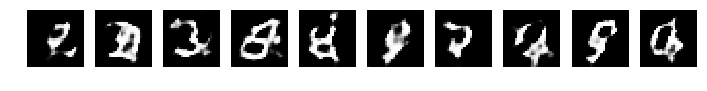

epoch:[2/5] batch:[180/469], [Discriminator::d_loss: 0.531667], [Generator::loss: 1.070008], 18[sec]


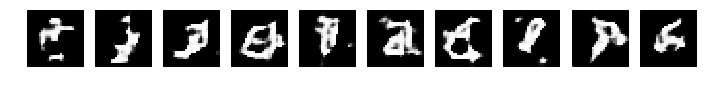

epoch:[2/5] batch:[200/469], [Discriminator::d_loss: 0.505903], [Generator::loss: 1.445154], 18[sec]


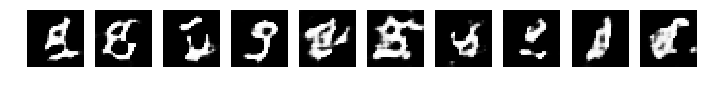

epoch:[2/5] batch:[220/469], [Discriminator::d_loss: 0.771838], [Generator::loss: 1.447632], 17[sec]


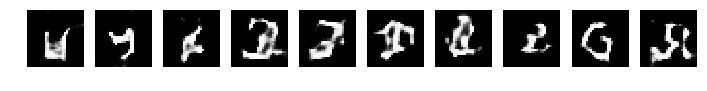

epoch:[2/5] batch:[240/469], [Discriminator::d_loss: 0.515521], [Generator::loss: 0.833446], 17[sec]


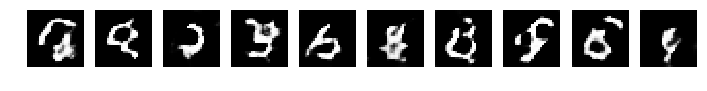

epoch:[2/5] batch:[260/469], [Discriminator::d_loss: 0.561701], [Generator::loss: 1.146890], 17[sec]


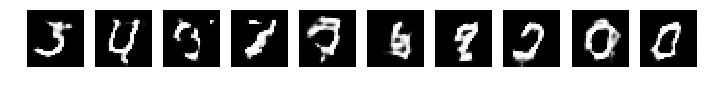

epoch:[2/5] batch:[280/469], [Discriminator::d_loss: 0.534621], [Generator::loss: 0.916575], 17[sec]


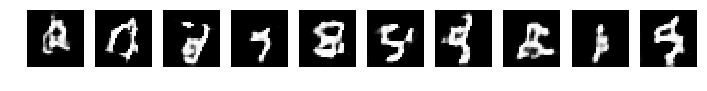

epoch:[2/5] batch:[300/469], [Discriminator::d_loss: 0.534879], [Generator::loss: 1.038104], 17[sec]


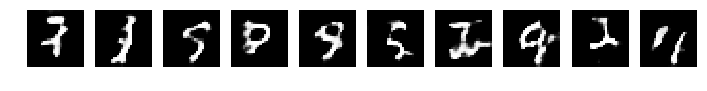

epoch:[2/5] batch:[320/469], [Discriminator::d_loss: 0.582899], [Generator::loss: 1.366769], 17[sec]


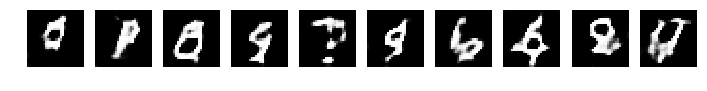

epoch:[2/5] batch:[340/469], [Discriminator::d_loss: 0.528747], [Generator::loss: 0.910950], 17[sec]


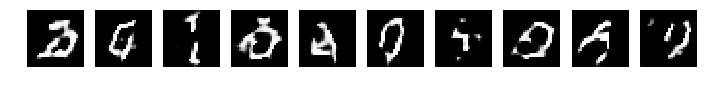

epoch:[2/5] batch:[360/469], [Discriminator::d_loss: 0.584553], [Generator::loss: 0.929476], 17[sec]


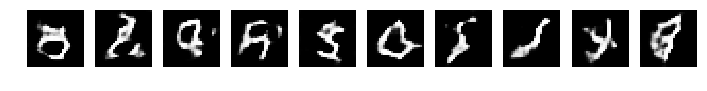

epoch:[2/5] batch:[380/469], [Discriminator::d_loss: 0.614170], [Generator::loss: 0.803088], 17[sec]


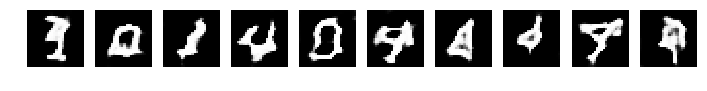

epoch:[2/5] batch:[400/469], [Discriminator::d_loss: 0.525128], [Generator::loss: 0.952373], 17[sec]


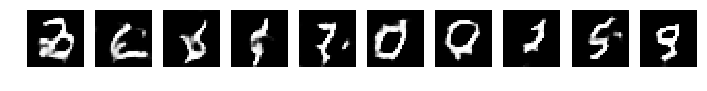

epoch:[2/5] batch:[420/469], [Discriminator::d_loss: 0.431723], [Generator::loss: 1.341218], 17[sec]


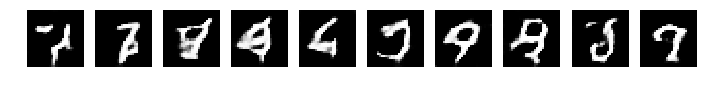

epoch:[2/5] batch:[440/469], [Discriminator::d_loss: 0.624626], [Generator::loss: 1.057813], 18[sec]


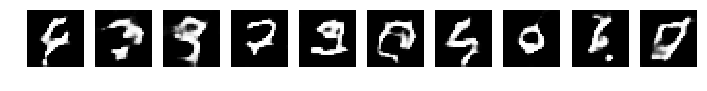

epoch:[2/5] batch:[460/469], [Discriminator::d_loss: 0.529855], [Generator::loss: 0.884516], 18[sec]


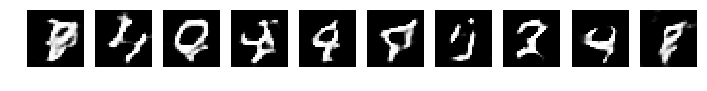

epoch:[3/5] batch:[20/469], [Discriminator::d_loss: 0.572706], [Generator::loss: 0.975996], 17[sec]


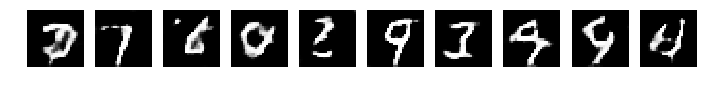

epoch:[3/5] batch:[40/469], [Discriminator::d_loss: 0.549507], [Generator::loss: 0.919948], 19[sec]


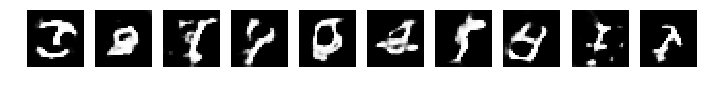

epoch:[3/5] batch:[60/469], [Discriminator::d_loss: 0.589587], [Generator::loss: 0.866109], 19[sec]


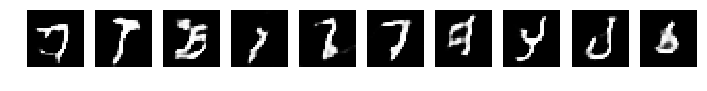

epoch:[3/5] batch:[80/469], [Discriminator::d_loss: 0.592239], [Generator::loss: 1.126698], 18[sec]


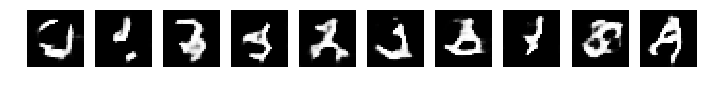

KeyboardInterrupt: 

In [45]:
t_i = time()
obj_gan.train(X_train,epochs=5,batch_size=128)
t_f = time()
print("------------------------------------------")
print("tempo de execução: ", (t_f-t_i)/60, "[min]")

In [8]:
print("tempo de execução: ", (t_f-t_i)/60, "[min]")

tempo de execução:  38.440340435504915 [min]


-- Imagens geradas pelo Gerador da GAN --


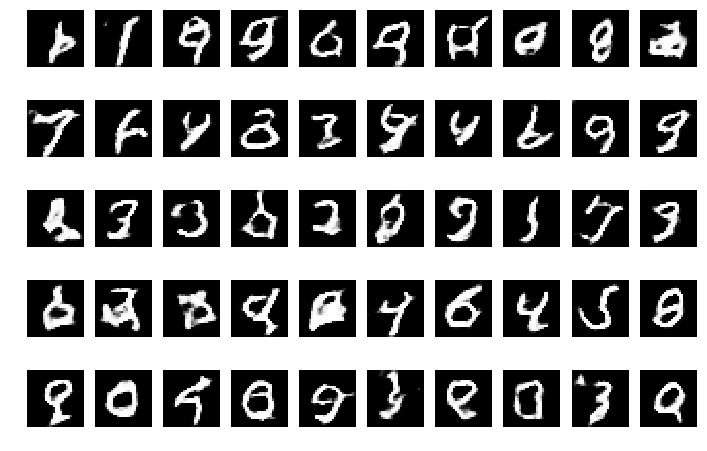

In [16]:
num_imgs = 50 #número de imágenes a mostrar aleatoriamente
x = np.random.normal(0,1,(num_imgs,1000))
img_pre = obj_gan.G.predict(x)
fig = plt.figure(figsize=(12,8))
print("-- Imagens geradas pelo Gerador da GAN --")
for i in range(num_imgs):
    ax=fig.add_subplot(5,10,i+1)
    plt.imshow(img_pre[i].reshape(28,28), cmap = plt.cm.Greys_r)
    ax.axis("off")

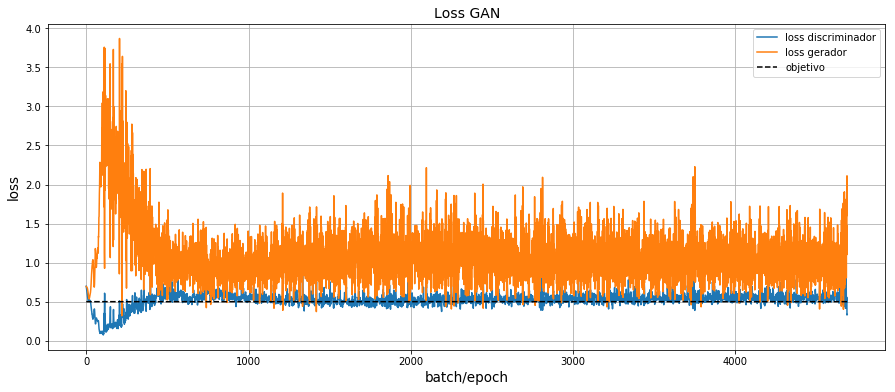

In [13]:
g_loss, d_loss = obj_gan.get_loss()

plt.figure(figsize=(15,6))
#plt.plot(range(len(g_loss)), g_loss)
plt.title("Loss GAN", fontsize=14)
plt.ylabel("loss", fontsize=13.5)
plts.xlabel("batch/epoch", fontsize=13.5)
plt.plot(range(np.array(d_loss).shape[0]), np.array(d_loss), label="loss discriminador")
plt.plot(range(np.array(g_loss).shape[0]), np.array(g_loss), label="loss gerador")
plt.plot(range(np.array(g_loss).shape[0]), 0.5*np.ones(np.array(g_loss).shape[0]),
         color="black", label="objetivo", linestyle='--')
plt.grid()
#plt.yticks([0, 0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])
plt.legend();

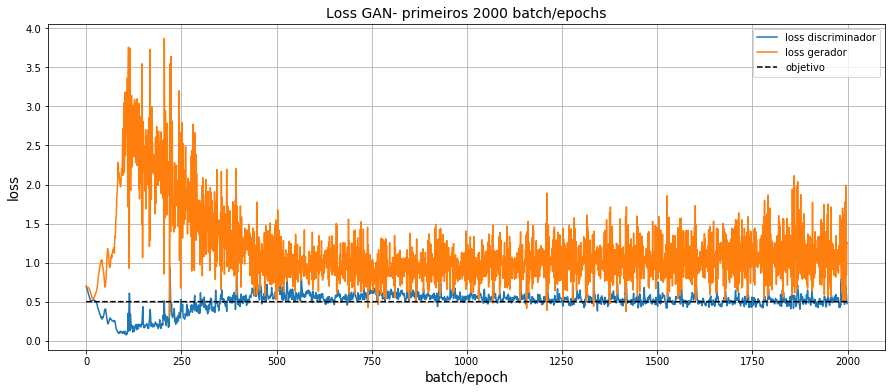

In [15]:
g_loss, d_loss = obj_gan.get_loss()

plt.figure(figsize=(15,6))
#plt.plot(range(len(g_loss)), g_loss)
plt.title("Loss GAN- primeiros 2000 batch/epochs", fontsize=14)
plt.ylabel("loss", fontsize=13.5)
plt.xlabel("batch/epoch", fontsize=13.5)
plt.plot(range(2000), np.array(d_loss[:2000]), label="loss discriminador")
plt.plot(range(2000), np.array(g_loss[:2000]), label="loss gerador")
plt.plot(range(2000), 0.5*np.ones(2000),
         color="black", label="objetivo", linestyle='--')
plt.grid()
#plt.yticks([0, 0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])
plt.legend();

In [1]:
from keras.datasets import cifar10

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 199s 1us/step


In [ ]:
for i in np.unique(y_train):
    print(sum(y_train==i))